# код для заметки блога "Scikit-Learn: тонкие вопросы о реализации методов машинного обучения"

https://dyakonov.org/2021/03/03/ml-scikit-learn/

In [87]:
import pandas as pd
import numpy as np
%pylab inline
plt.style.use('seaborn-dark')
import warnings
warnings.filterwarnings("ignore") # отключение варнингов
pd.set_option('display.max_columns', None) # pd.options.display.max_columns = None 
# pd.set_option('display.max_rows', None) # не прятать столбцы при выводе дата-фреймов
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('font', size=14)

Populating the interactive namespace from numpy and matplotlib


In [88]:
# для картинки
from dj_booklib_v3 import *

## к вопросу о svm

предсказания: [0 1]
вероятности: [0.64550527 0.35658176]
[-0.891277055847369, 0, 0.8912770558473689]


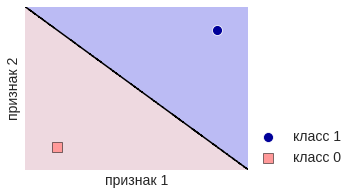

In [89]:
X = [[0, 0], [1, 1]] # обучение 
y = [0, 1]
X2 = X.copy() # контроль

from sklearn.svm import SVC
svm = SVC(kernel='rbf', gamma=1.0, probability=True)
svm.fit(X, y)

a = svm.predict(X2)
p = svm.predict_proba(X2)
print (f'предсказания: {a}')
print (f'вероятности: {p[:,1]}')



X = np.array(X)
y = np.array(y)

plt.figure(figsize=(4, 3))
plot_2d_separator(svm, X, fill=True, twocolor=True);
show_scatter(X[:, 0], X[: ,1], y, figsize=(4, 3.5),
             size=100, eps=0.2, newfig=False, show_legend=True);

In [90]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(base_estimator=svm)
calibrated_clf.fit(X, y)
calibrated_clf.predict_proba(X)

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=2.

In [91]:
X = [[0, 0], [1, 1]] # обучение 
y = [0, 1]
X2 = X.copy() # контроль

X = X * 10 # дублируем объекты
y = y * 10

from sklearn.svm import SVC
svm = SVC(kernel='rbf', gamma=1.0, probability=True)
svm.fit(X, y)

a = svm.predict(X2)
p = svm.predict_proba(X2)
print (f'предсказания: {a}')
print (f'вероятности: {p[:,1]}')

предсказания: [0 1]
вероятности: [0.08333339 0.91680141]


In [ ]:
class sklearn.linear_model.Ridge(alpha=1.0, # Regularization strength
                                 fit_intercept=True, normalize=False,
                                 copy_X=True, max_iter=None, tol=0.001,
                                 solver='auto', random_state=None)

In [ ]:
class sklearn.svm.SVC(C=1.0, # Regularization parameter
                      kernel='rbf', degree=3, gamma='scale', coef0=0.0,
                      shrinking=True, probability=False, tol=0.001,
                      cache_size=200, class_weight=None, verbose=False,
                      max_iter=- 1, decision_function_shape='ovr',
                      break_ties=False, random_state=None)

## к вопросу о lgb

In [92]:
X = np.random.rand(100000, 20)
y = (X[:,0] + X[:,1])*(X[:,2] - X[:, 3])
X.shape, y.shape

((100000, 20), (100000,))

In [93]:
%time
import lightgbm as lgb

params = {'objective': 'regression',
          'boosting_type': 'gbdt',
          'learning_rate': 0.1}

cv_results = lgb.cv(params,
                    lgb.Dataset(X, y),
                    num_boost_round=100,
                    nfold=10, # cv.split(X), # 10,
                    metrics='rmse',
                    stratified=False
                    )

print (f"rmse = {cv_results['rmse-mean'][99]}")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
rmse = 0.02065529588662666


(0, 0.4)

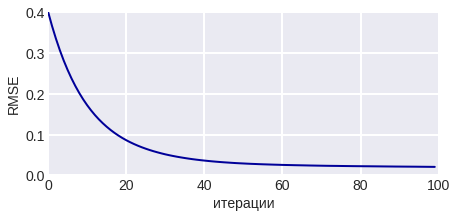

In [94]:
plt.figure(figsize=(7, 3))
plt.plot(cv_results['rmse-mean'], lw=2, c='#000099')
plt.xlabel('итерации')
plt.ylabel('RMSE')
plt.grid(lw=2)
plt.xlim([0, 100])
plt.ylim([0, 0.4])

In [95]:
%time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

model = lgb.LGBMRegressor() # модель
cv = KFold(n_splits=10, random_state=1) # способ контроля

scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
print (f'rmse = {-mean(scores)}')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
rmse = 0.020629265953391353


In [96]:
lgb.LGBMRegressor()

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [97]:
%time
import lightgbm as lgb
# параметры модели
params = {'objective': 'regression',
          'boosting_type': 'gbdt',
          'learning_rate': 0.1}
# контроль
cv_results = lgb.cv(params,
                    lgb.Dataset(X, y),
                    num_boost_round=100,
                    folds=cv,
                    metrics='rmse',
                    # stratified=False
                    )

print (f"rmse = {cv_results['rmse-mean'][-1]}")

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 6.2 µs
rmse = 0.02065176102281662


## Пример с дисбалансом

In [86]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4, random_state=1, shuffle=False)
x = np.arange(10)
y = [1,1,1,0,0,0,0,0,0,0]

for i, (train_index, test_index) in enumerate(skf.split(x, y)):
    print (i, 'train:', train_index, 'test:', test_index)

0 train: [1 2 5 6 7 8 9] test: [0 3 4]
1 train: [0 2 3 4 7 8 9] test: [1 5 6]
2 train: [0 1 3 4 5 6 8 9] test: [2 7]
3 train: [0 1 2 3 4 5 6 7] test: [8 9]
